Generating graph with 100 nodes and 3 classes...

Dataset statistics:
Number of nodes: 100
Number of features: 8
Number of edges: 801
Number of classes: 3
Class distribution: [34, 33, 33]
Training nodes: 60
Validation nodes: 20
Test nodes: 20

Visualizing original graph structure...


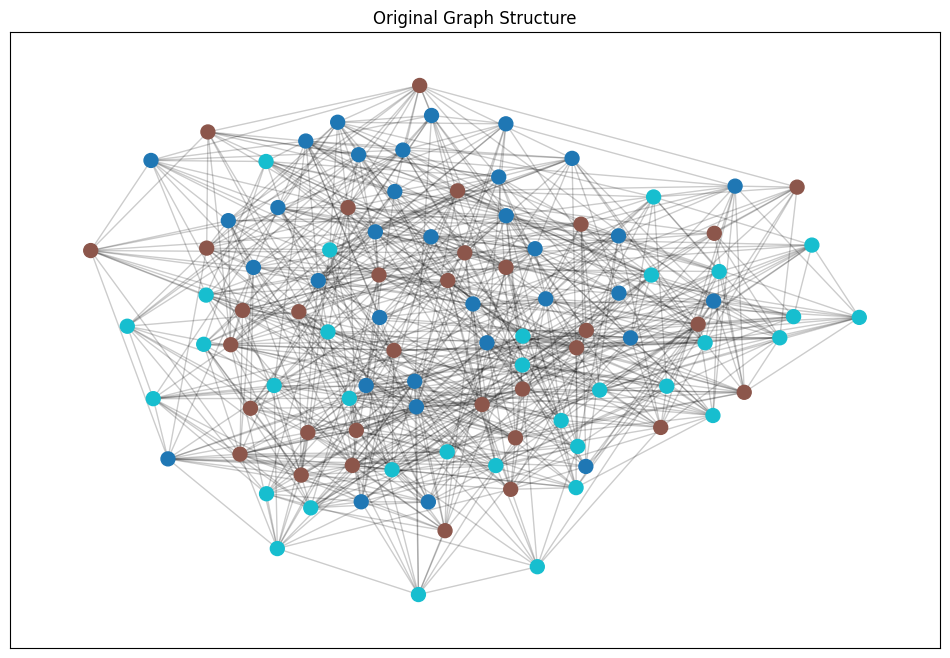


Starting training...
Epoch: 020, Loss: 0.8289, Train Acc: 0.9000, Val Acc: 1.0000

Early stopping at epoch 34


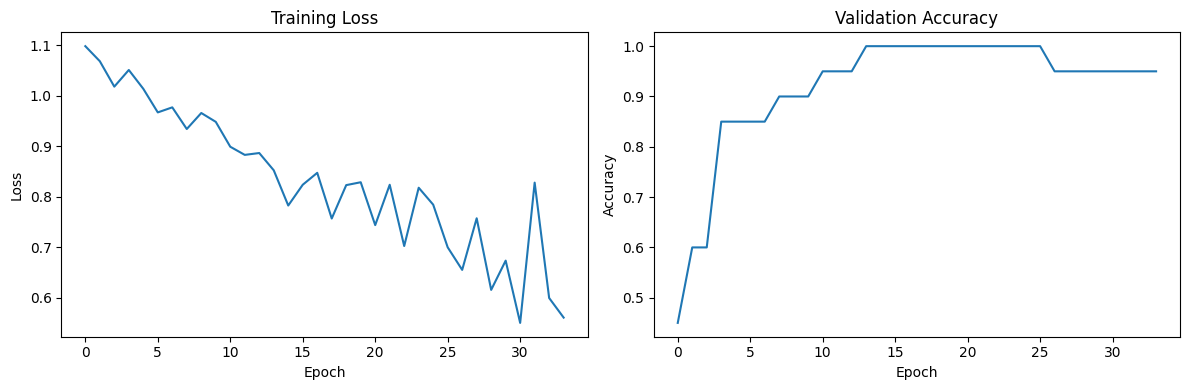


Test Accuracy: 0.9500

Visualizing predictions vs true labels...


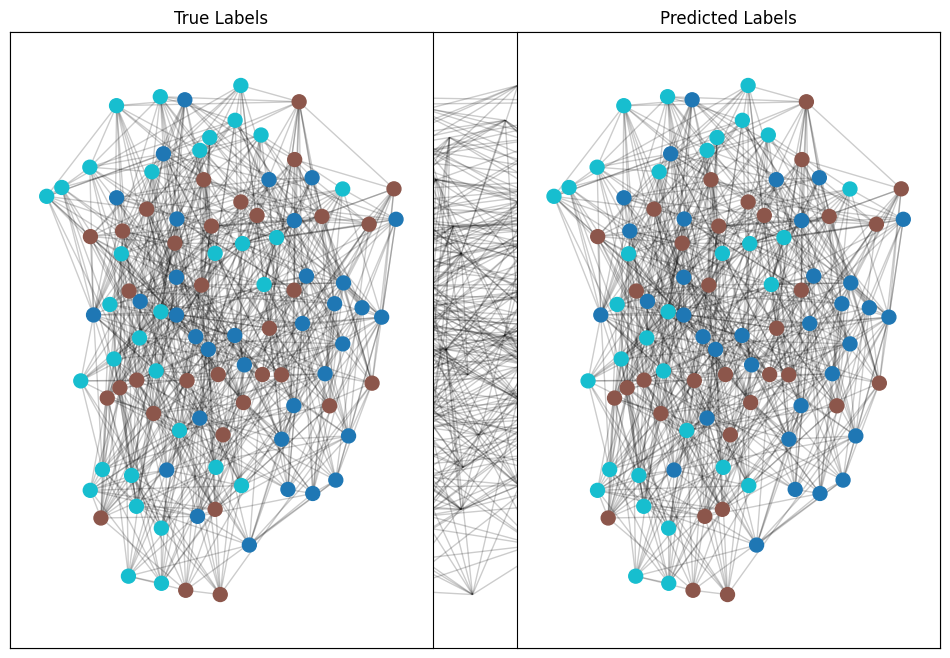

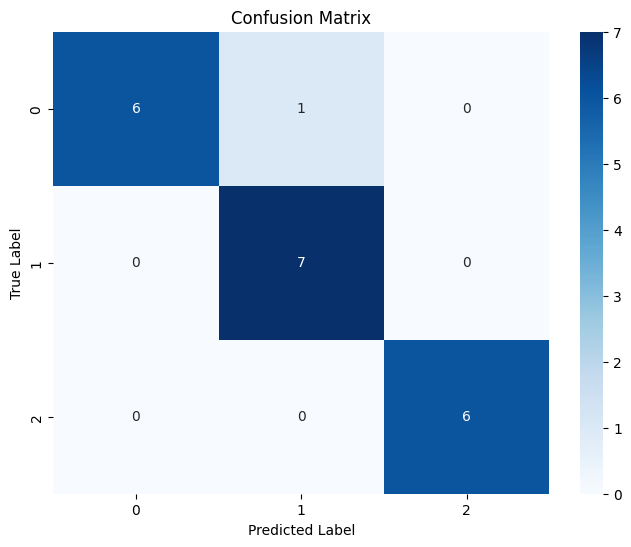


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.86      0.92         7
           1       0.88      1.00      0.93         7
           2       1.00      1.00      1.00         6

    accuracy                           0.95        20
   macro avg       0.96      0.95      0.95        20
weighted avg       0.96      0.95      0.95        20



In [4]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Generate synthetic dataset
def generate_community_graph(num_nodes=100, num_classes=3, connection_prob=0.3):
    """
    Generate a synthetic graph with community structure where nodes in the same community
    are more likely to be connected and have similar features.
    """
    # Calculate nodes per class, handling uneven division
    base_nodes_per_class = num_nodes // num_classes
    extra_nodes = num_nodes % num_classes
    
    # Distribute nodes among classes
    class_sizes = [base_nodes_per_class + (1 if i < extra_nodes else 0) 
                  for i in range(num_classes)]
    
    # Create class labels
    node_classes = []
    for class_idx, size in enumerate(class_sizes):
        node_classes.extend([class_idx] * size)
    
    node_classes = np.array(node_classes)
    assert len(node_classes) == num_nodes  # Verification
    
    # Generate node features
    feature_dim = 8
    features = []
    for class_idx in node_classes:
        # Base feature vector for each class
        base_feature = np.zeros(feature_dim)
        base_feature[class_idx * (feature_dim // num_classes):(class_idx + 1) * (feature_dim // num_classes)] = 1
        # Add noise
        noise = np.random.normal(0, 0.1, feature_dim)
        features.append(base_feature + noise)
    
    features = np.array(features)
    
    # Generate edges
    edge_index = []
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            # Higher probability of connection if nodes are in the same class
            if node_classes[i] == node_classes[j]:
                prob = connection_prob
            else:
                prob = connection_prob * 0.3
                
            if np.random.random() < prob:
                edge_index.extend([[i, j], [j, i]])  # Add bidirectional edges
    
    # Ensure we have at least some edges
    if not edge_index:
        # Add some minimal connections if no edges were generated
        for i in range(num_nodes - 1):
            edge_index.extend([[i, i + 1], [i + 1, i]])
    
    edge_index = np.array(edge_index).T
    
    # Convert to PyTorch tensors
    x = torch.FloatTensor(features)
    edge_index = torch.LongTensor(edge_index)
    y = torch.LongTensor(node_classes)
    
    # Create train/val/test masks
    indices = np.random.permutation(num_nodes)
    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    val_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)
    
    # Calculate split sizes
    train_size = int(0.6 * num_nodes)
    val_size = int(0.2 * num_nodes)
    
    train_mask[indices[:train_size]] = True
    val_mask[indices[train_size:train_size + val_size]] = True
    test_mask[indices[train_size + val_size:]] = True
    
    return x, edge_index, y, train_mask, val_mask, test_mask

# Define GAT model
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8, dropout=0.6):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        # Output layer with mean aggregation (heads=1)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=dropout)
        
    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

def train(model, x, edge_index, y, train_mask, optimizer):
    model.train()
    optimizer.zero_grad()
    out = model(x, edge_index)
    loss = F.nll_loss(out[train_mask], y[train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(model, x, edge_index, y, mask):
    model.eval()
    with torch.no_grad():
        out = model(x, edge_index)
        pred = out.argmax(dim=1)
        correct = pred[mask] == y[mask]
        acc = int(correct.sum()) / int(mask.sum())
    return acc, pred

def visualize_graph(x, edge_index, y, pred=None, title="Graph Visualization"):
    """Visualize the graph with node colors based on classes"""
    # Move tensors to CPU if they're on GPU
    edge_index = edge_index.cpu()
    y = y.cpu()
    if pred is not None:
        pred = pred.cpu()
    
    G = nx.Graph()
    edge_list = edge_index.t().numpy()
    
    # Add edges to the graph
    for i in range(edge_list.shape[0]):
        G.add_edge(edge_list[i, 0], edge_list[i, 1])
    
    # Create layout
    pos = nx.spring_layout(G)
    
    plt.figure(figsize=(12, 8))
    
    # Draw edges
    nx.draw_networkx_edges(G, pos, alpha=0.2)
    
    # Draw nodes
    if pred is None:
        # Color nodes by true labels
        nx.draw_networkx_nodes(G, pos, node_color=y.numpy(), 
                             cmap=plt.cm.tab10, node_size=100)
        plt.title(title)
    else:
        # Side by side visualization
        plt.subplot(1, 2, 1)
        nx.draw_networkx_edges(G, pos, alpha=0.2)
        nx.draw_networkx_nodes(G, pos, node_color=y.numpy(), 
                             cmap=plt.cm.tab10, node_size=100)
        plt.title("True Labels")
        
        plt.subplot(1, 2, 2)
        nx.draw_networkx_edges(G, pos, alpha=0.2)
        nx.draw_networkx_nodes(G, pos, node_color=pred.numpy(), 
                             cmap=plt.cm.tab10, node_size=100)
        plt.title("Predicted Labels")
    
    plt.show()
    
def plot_training_curve(train_losses, val_accuracies):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies)
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, num_classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def main():
    # Set random seed for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    
    # Generate synthetic dataset
    num_nodes = 100
    num_classes = 3
    print(f"Generating graph with {num_nodes} nodes and {num_classes} classes...")
    
    x, edge_index, y, train_mask, val_mask, test_mask = generate_community_graph(
        num_nodes=num_nodes, num_classes=num_classes)
    
    # Print dataset statistics
    print(f"\nDataset statistics:")
    print(f"Number of nodes: {x.shape[0]}")
    print(f"Number of features: {x.shape[1]}")
    print(f"Number of edges: {edge_index.shape[1] // 2}")  # Divide by 2 because edges are bidirectional
    print(f"Number of classes: {len(torch.unique(y))}")
    print(f"Class distribution: {torch.bincount(y).tolist()}")
    print(f"Training nodes: {train_mask.sum().item()}")
    print(f"Validation nodes: {val_mask.sum().item()}")
    print(f"Test nodes: {test_mask.sum().item()}")
    
    # Visualize original graph
    print("\nVisualizing original graph structure...")
    visualize_graph(x, edge_index, y, title="Original Graph Structure")
    
    # Initialize model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = GAT(in_channels=x.size(1), hidden_channels=8, 
                out_channels=num_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
    
    # Move data to device
    x = x.to(device)
    edge_index = edge_index.to(device)
    y = y.to(device)
    
    # Training
    print("\nStarting training...")
    train_losses = []
    val_accuracies = []
    best_val_acc = 0
    patience = 20
    patience_counter = 0
    
    for epoch in range(200):
        loss = train(model, x, edge_index, y, train_mask, optimizer)
        train_acc, _ = evaluate(model, x, edge_index, y, train_mask)
        val_acc, _ = evaluate(model, x, edge_index, y, val_mask)
        
        train_losses.append(loss)
        val_accuracies.append(val_acc)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f'\nEarly stopping at epoch {epoch+1}')
            break
        
        if (epoch + 1) % 20 == 0:
            print(f'Epoch: {epoch+1:03d}, Loss: {loss:.4f}, '
                  f'Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')
    
    # Plot training curves
    plot_training_curve(train_losses, val_accuracies)
    
    # Final evaluation
    test_acc, pred = evaluate(model, x, edge_index, y, test_mask)
    print(f'\nTest Accuracy: {test_acc:.4f}')
    
    # Visualize predictions
    print("\nVisualizing predictions vs true labels...")
    visualize_graph(x, edge_index, y, pred.cpu(), "Prediction Results")
    
    # Plot confusion matrix for test set
    y_test = y[test_mask].cpu().numpy()
    pred_test = pred[test_mask].cpu().numpy()
    plot_confusion_matrix(y_test, pred_test, num_classes)
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, pred_test))

if __name__ == '__main__':
    main()